# SemScore-DSPy

<img src="logo/SemScore-DSPy-2.svg" alt="SemScore-DSPy Logo" style="width:400px; height:auto;">


### Use SemScore Metric

#### DSPy

#### Pytorch

### Validation of SemScore Metric

Debug the `SemScoreValidator`

In [1]:
from semscore.utils.validation import SemScoreValidator
validator = SemScoreValidator(reference_file="semscore/data/reference/semscores_OA-100.json")
validator.debug_reference_file()

Successfully loaded reference file
Number of models: 2

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Number of cases: 154
First case keys: ['prompt', 'answer_ref', 'answer_pred', 'cosine_sim']

Model: models/Mistral-7B-Instruct-v0.2
Number of cases: 154
First case keys: ['prompt', 'answer_ref', 'answer_pred', 'cosine_sim']


Run validation to validate the SemScore metric against a reference: [Link](https://github.com/geronimi73/semscore/blob/main/nb_blog_part1_OA-conversations-results/semscores_OA-100.json).

Please see the validation results in the `validation_results` folder.

In [6]:
from semscore.utils.validation import run_validation
from IPython.display import Markdown, display


# Run validation with your dataset
report = run_validation(
    output_dir="validation_results",
    reference_file="semscore/data/reference/semscores_OA-100.json"
)

# The report will be saved to the output directory
# and returned as a string
display(Markdown(report))


# SemScore Validation Report
Generated on: 2024-12-22 01:31:25

## OpenAssistant Dataset Results

### TinyLlama/TinyLlama-1.1B-Chat-v1.0


Performance Metrics:
- Pearson Correlation: 1.0000
- Mean Absolute Difference: 0.0000
- Mean Calculated Score: 0.6974
- Mean Reference Score: 0.6974

Example Cases:
| Prompt | Prediction | Reference | Calculated | Expected | Diff |
|--------|------------|-----------|------------|-----------|------|
| <|user|> Can photoshop be used as a tool to forge ... | Yes, photoshop can be used as a tool to forge docu... | Yes, Photoshop can be used to forge documents due ... | 0.9537 | 0.9537 | 0.0000 |
| <|user|> What is the difference between C# and Jav... | Certainly! Here are some key differences between C... | Sure, I can provide you with a comparison between ... | 0.8042 | 0.8042 | 0.0000 |
| <|user|> Explain GPIO pins on a raspberry pi pico ... | GPIO (General Purpose Input/Output) pins are used ... | GPIO (General Purpose Input/Output) pins are physi... | 0.8529 | 0.8529 | 0.0000 |

### models/Mistral-7B-Instruct-v0.2


Performance Metrics:
- Pearson Correlation: 1.0000
- Mean Absolute Difference: 0.0000
- Mean Calculated Score: 0.7372
- Mean Reference Score: 0.7372

Example Cases:
| Prompt | Prediction | Reference | Calculated | Expected | Diff |
|--------|------------|-----------|------------|-----------|------|
| <s>[INST] Can photoshop be used as a tool to forge... | Yes, Adobe Photoshop and similar image editing sof... | Yes, Photoshop can be used to forge documents due ... | 0.8402 | 0.8402 | 0.0000 |
| <s>[INST] What is the difference between C# and Ja... | Both C# and Java are popular programming languages... | Sure, I can provide you with a comparison between ... | 0.9332 | 0.9332 | 0.0000 |
| <s>[INST] Explain GPIO pins on a raspberry pi pico... | The Raspberry Pi Pico W is a microcontroller board... | GPIO (General Purpose Input/Output) pins are physi... | 0.7874 | 0.7874 | 0.0000 |


In [7]:
from IPython.core.display import HTML

# HTML template for displaying images side by side
html_template = """
<div style="display: flex; justify-content: space-around; align-items: center;">
    <img src="{path1}" style="width: 45%; margin: 10px;">
    <img src="{path2}" style="width: 45%; margin: 10px;">
</div>
<div style="display: flex; justify-content: space-around; align-items: center;">
    <img src="{path3}" style="width: 45%; margin: 10px;">
    <img src="{path4}" style="width: 45%; margin: 10px;">
</div>
"""

display(HTML(html_template.format(
    path1="validation_results/score_dist_models_Mistral-7B-Instruct-v0.2_calculated_20241222_013110.png",
    path2="validation_results/score_dist_models_Mistral-7B-Instruct-v0.2_expected_20241222_013110.png",
    path3="validation_results/score_dist_TinyLlama_TinyLlama-1.1B-Chat-v1.0_calculated_20241222_013110.png",
    path4="validation_results/score_dist_TinyLlama_TinyLlama-1.1B-Chat-v1.0_expected_20241222_013110.png"
)))


Given the report and the histograms, it is fair to say that the SemScore metric produces the same output as the reference implementation. 

### Characterization of SemScore Metric

This section demonstrates a complete workflow for characterizing semantic similarity scoring using the SemScore package.

#### 1. Setup and Imports


Let's first import the required packages and set up our environment.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure seaborn is installed: pip install seaborn
from pathlib import Path
import json

# Import SemScore modules
from semscore.metric.core import SemScoreMetric
from semscore.characterization.statistics import analyze_distribution
from semscore.characterization.distributions import (
    analyze_category_distributions,
    generate_bootstrap_distributions,
    validate_distributions
)
from semscore.characterization.visualization import SemScoreVisualizer

# Set plotting styles using seaborn directly
sns.set_theme(style="whitegrid")  # Instead of plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]

#### 2. Load and Process Data


Now we'll load our characterization dataset and compute semantic scores for each text pair.
The dataset contains pairs of texts with known semantic relationships (identical, paraphrase, different, etc.).

In [2]:
# Load the characterization dataset
data_path = Path('semscore/data/characterization/SemScore_Characterization_Dataset.json')
with open(data_path, 'r') as f:
    raw_data = json.load(f)

# Initialize SemScore metric
metric = SemScoreMetric()

# Dictionary to store scores by category
category_scores = {}

# Compute semantic scores for each pair
for item in raw_data:
    category = item['category']
    # Compute score for text pair
    score = metric(item['text1'], item['text2'])
    
    # Store in appropriate category
    if category not in category_scores:
        category_scores[category] = []
    category_scores[category].append(score)

# Convert lists to numpy arrays
scores = {cat: np.array(scores) for cat, scores in category_scores.items()}

# Print basic information
print("Categories found:", list(scores.keys()))
print("\nSample sizes:")
for cat, data in scores.items():
    print(f"{cat}: {len(data)} samples")

Categories found: ['Identical', 'Paraphrase', 'Similar Content', 'Related Topic', 'Different Domain', 'Unrelated', 'Contradiction']

Sample sizes:
Identical: 84 samples
Paraphrase: 81 samples
Similar Content: 70 samples
Related Topic: 70 samples
Different Domain: 70 samples
Unrelated: 70 samples
Contradiction: 78 samples


#### 3. Set Up Output Directory


First, let's create an output directory for all our results and visualizations.

In [3]:
# Create output directory
output_dir = Path('semscore_characterization_results')
output_dir.mkdir(exist_ok=True)

# Initialize visualizer with output directory
visualizer = SemScoreVisualizer(
    output_dir=str(output_dir),
    figsize=(12, 8),
    dpi=300
)

print(f"Output directory created: {output_dir}")

Output directory created: semscore_characterization_results


#### 4. Validate Distributions

Before detailed analysis, let's validate our score distributions to ensure data quality.

In [4]:
# Run distribution validation
validation_results = validate_distributions(scores)

# Save validation results to file
validation_report = []
for category, messages in validation_results.items():
    validation_report.append(f"\n{category}:")
    if messages:
        for msg in messages:
            validation_report.append(f"- {msg}")
    else:
        validation_report.append("- All checks passed")

# Write validation report
with open(output_dir / 'validation_report.txt', 'w') as f:
    f.write('\n'.join(validation_report))

# Display validation results
print("Validation Results:")
print('\n'.join(validation_report))

Validation Results:

Identical:
- Contains 27 scores outside valid range [0,1]: min=1.00, max=1.00
- Non-normal distribution (p=0.0013)

Paraphrase:
- Non-normal distribution (p=0.0002)

Similar Content:
- All checks passed

Related Topic:
- Contains 4 scores outside valid range [0,1]: min=-0.06, max=-0.01

Different Domain:
- Contains 6 scores outside valid range [0,1]: min=-0.18, max=-0.01

Unrelated:
- Contains 42 scores outside valid range [0,1]: min=-0.13, max=-0.00

Contradiction:
- Non-normal distribution (p=0.0104)


#### 5. Statistical Analysis


Now let's perform comprehensive statistical analysis of the distributions.

In [8]:
# Perform category distribution analysis
results = analyze_category_distributions(scores)

# Generate bootstrap distributions
bootstrap_data = generate_bootstrap_distributions(
    scores,
    n_bootstrap=10000,
    random_state=42
)

# Create statistical summary
summary = []
summary.append("Statistical Summary\n")

# Category statistics
summary.append("Category Statistics:")
for category in results.categories:
    summary.append(f"\n{category}:")
    summary.append(f"Mean: {results.means[category]:.3f}")
    summary.append(f"Std: {results.stds[category]:.3f}")
    summary.append(f"Sample size: {results.sample_sizes[category]}")
    if category in results.normality_tests:
        stat, p_val = results.normality_tests[category]
        summary.append(f"Normality test p-value: {p_val:.3f}")

# Effect sizes
summary.append("\nEffect Sizes:")
for (cat1, cat2), comparison in results.effect_sizes.items():
    summary.append(f"\n{cat1} vs {cat2}:")
    summary.append(f"Cohen's d: {comparison.cohens_d:.3f}")
    summary.append(f"CLES: {comparison.cles:.3f}")
    summary.append(f"Mean difference: {comparison.mean_diff:.3f}")
    summary.append(f"95% CI: [{comparison.ci_diff_lower:.3f}, {comparison.ci_diff_upper:.3f}]")

# Save summary report
with open(output_dir / 'statistical_summary.txt', 'w') as f:
    f.write('\n'.join(summary))

# Display summary
print('\n'.join(summary))

Statistical Summary

Category Statistics:

Identical:
Mean: 1.000
Std: 0.000
Sample size: 84
Normality test p-value: 0.001

Paraphrase:
Mean: 0.822
Std: 0.098
Sample size: 81
Normality test p-value: 0.000

Similar Content:
Mean: 0.556
Std: 0.179
Sample size: 70
Normality test p-value: 0.640

Related Topic:
Mean: 0.338
Std: 0.219
Sample size: 70
Normality test p-value: 0.412

Different Domain:
Mean: 0.134
Std: 0.120
Sample size: 70
Normality test p-value: 0.243

Unrelated:
Mean: -0.011
Std: 0.051
Sample size: 70
Normality test p-value: 0.710

Contradiction:
Mean: 0.752
Std: 0.191
Sample size: 78
Normality test p-value: 0.010

Effect Sizes:

Identical vs Paraphrase:
Cohen's d: 2.569
CLES: 1.000
Mean difference: 0.178
95% CI: [0.157, 0.200]

Identical vs Similar Content:
Cohen's d: 3.651
CLES: 1.000
Mean difference: 0.444
95% CI: [0.402, 0.486]

Identical vs Related Topic:
Cohen's d: 4.464
CLES: 1.000
Mean difference: 0.662
95% CI: [0.610, 0.714]

Identical vs Different Domain:
Cohen's d:

Characterization complete. All results saved to: semscore_characterization_results


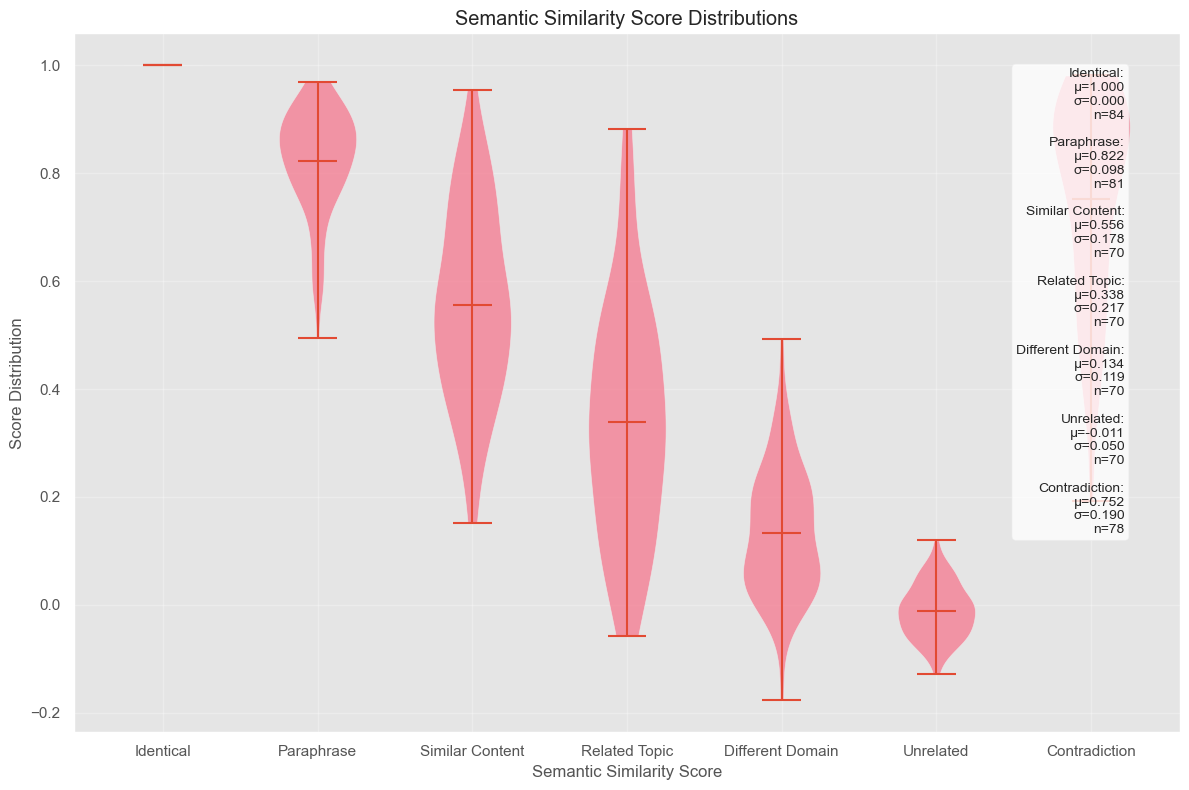

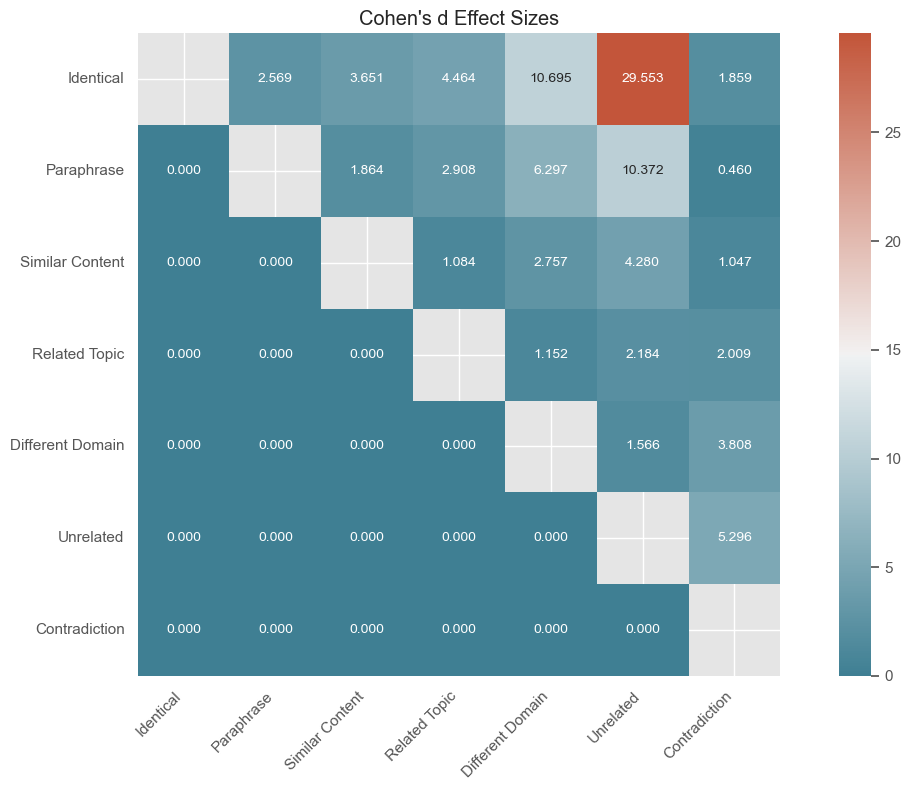

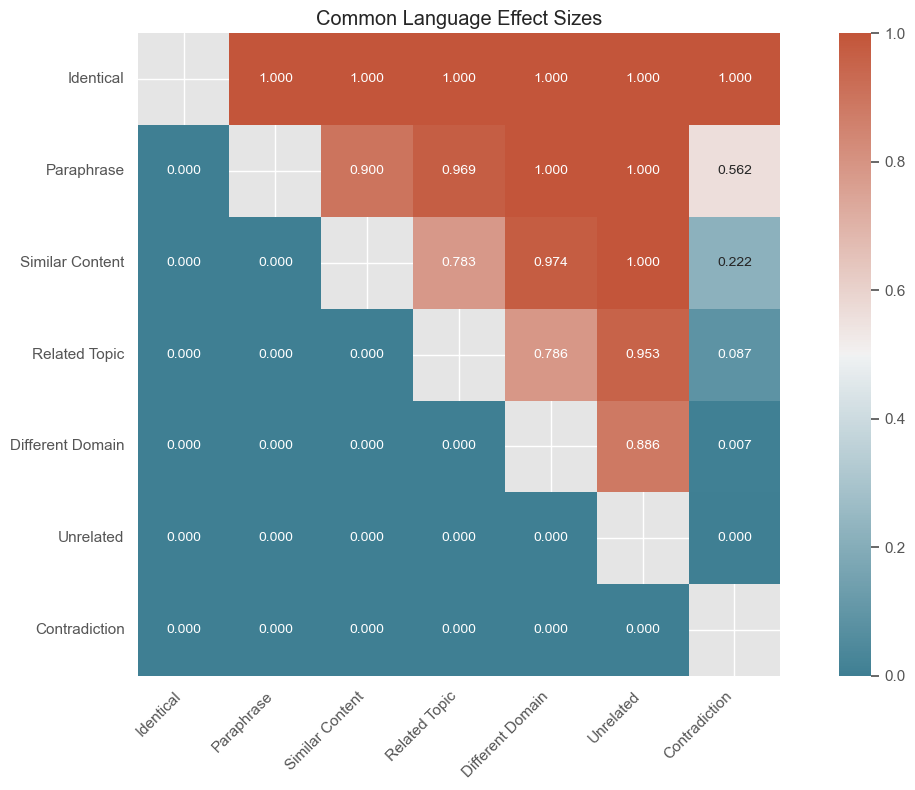

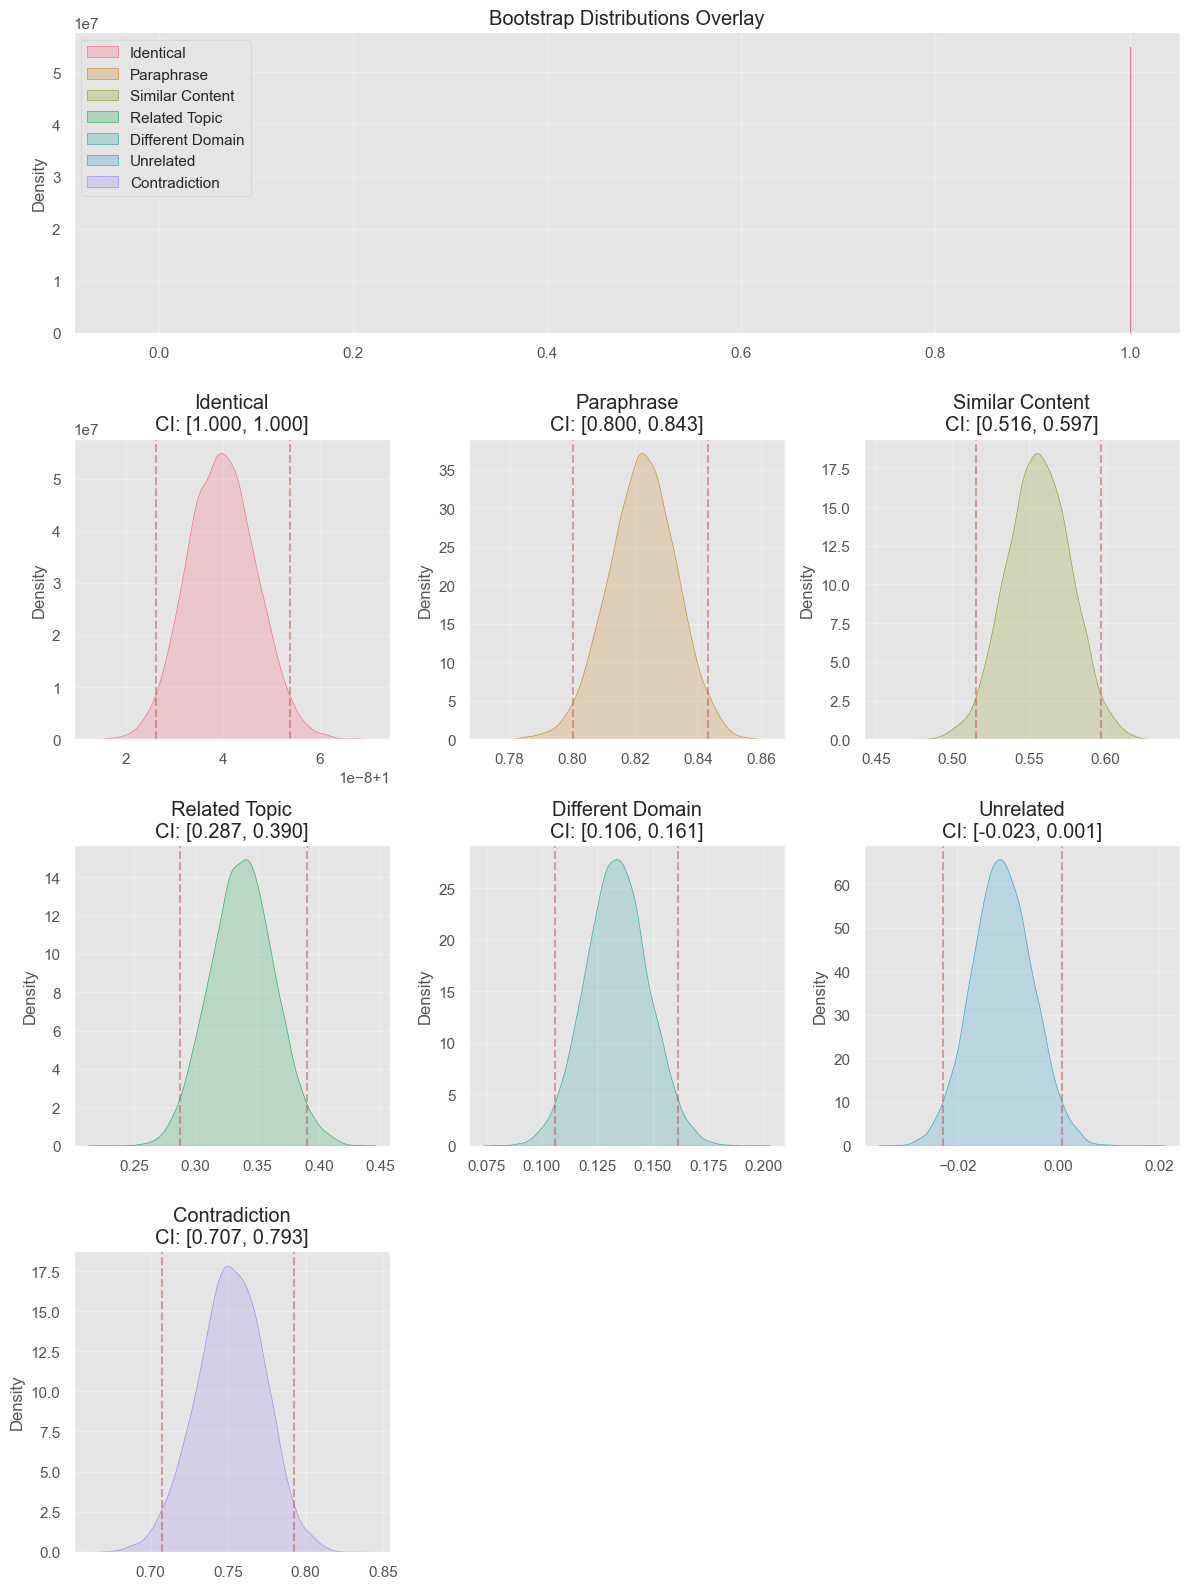

In [10]:
# Create output directory to store all results and visualizations
output_dir = Path('semscore_characterization_results')
output_dir.mkdir(exist_ok=True)  # Create directory if it doesn't exist

# Initialize the visualizer with desired settings
visualizer = SemScoreVisualizer(
    output_dir=str(output_dir),  # Set output path for saving plots
    figsize=(12, 8),  # Set default figure size (width, height) in inches
    dpi=300  # Set resolution for saved figures
)

# Load and process the characterization dataset
data_path = Path('semscore/data/characterization/SemScore_Characterization_Dataset.json')
with open(data_path, 'r') as f:
    raw_data = json.load(f)  # Load the JSON dataset containing text pairs

# Initialize the semantic similarity metric
metric = SemScoreMetric()  # Creates instance of our similarity metric

# Dictionary to store scores organized by category
category_scores = {}

# Process each text pair in the dataset
for item in raw_data:
    category = item['category']  # Get the semantic relationship category
    # Compute semantic similarity score for the text pair
    score = metric(item['text1'], item['text2'])
    
    # Initialize category list if not exists
    if category not in category_scores:
        category_scores[category] = []
    # Store the computed score in appropriate category
    category_scores[category].append(score)

# Convert score lists to numpy arrays for efficient computation
scores = {cat: np.array(scores) for cat, scores in category_scores.items()}

# Perform initial data validation
validation_results = validate_distributions(scores)

# Create validation report
validation_report = ["SemScore Characterization Validation Report\n"]
for category, messages in validation_results.items():
    validation_report.append(f"\nCategory: {category}")
    if messages:
        for msg in messages:
            validation_report.append(f"- {msg}")
    else:
        validation_report.append("- All validation checks passed")

# Save validation report
with open(output_dir / 'validation_report.txt', 'w') as f:
    f.write('\n'.join(validation_report))

# Perform comprehensive statistical analysis
results = analyze_category_distributions(scores)

# Generate bootstrap distributions for uncertainty estimation
# Using 10000 resamples for stable estimates
bootstrap_data = generate_bootstrap_distributions(
    scores,
    n_bootstrap=10000,
    random_state=42  # Set seed for reproducibility
)

# Create detailed statistical summary
summary = ["SemScore Statistical Analysis Summary\n"]

# Add category-level statistics
summary.append("Category Statistics:")
for category in results.categories:
    summary.append(f"\n{category}:")
    summary.append(f"Sample size: {results.sample_sizes[category]}")
    summary.append(f"Mean similarity: {results.means[category]:.4f}")
    summary.append(f"Standard deviation: {results.stds[category]:.4f}")
    if category in results.normality_tests:
        stat, p_val = results.normality_tests[category]
        summary.append(f"Normality test p-value: {p_val:.4f}")

# Add pairwise comparisons and effect sizes
summary.append("\nPairwise Comparisons:")
for (cat1, cat2), comparison in results.effect_sizes.items():
    summary.append(f"\n{cat1} vs {cat2}:")
    summary.append(f"Cohen's d: {comparison.cohens_d:.4f}")
    summary.append(f"CLES: {comparison.cles:.4f}")
    summary.append(f"Mean difference: {comparison.mean_diff:.4f}")
    summary.append(f"95% CI: [{comparison.ci_diff_lower:.4f}, {comparison.ci_diff_upper:.4f}]")
    summary.append(f"KS-test p-value: {comparison.ks_pvalue:.4f}")

# Save statistical summary
with open(output_dir / 'statistical_summary.txt', 'w') as f:
    f.write('\n'.join(summary))

# Generate visualization suite
# 1. Category distribution plots
visualizer.plot_category_distributions(
    scores,
    title="Semantic Similarity Score Distributions",
    show_stats=True  # Include statistical annotations
)

# 2. Create effect size matrices for visualization
categories = list(scores.keys())
n_cats = len(categories)

# Initialize effect size matrices
cohens_d_matrix = np.zeros((n_cats, n_cats))
cles_matrix = np.zeros((n_cats, n_cats))

# Fill effect size matrices
for i, cat1 in enumerate(categories):
    for j, cat2 in enumerate(categories):
        if (cat1, cat2) in results.effect_sizes:
            comparison = results.effect_sizes[(cat1, cat2)]
            cohens_d_matrix[i,j] = comparison.cohens_d
            cles_matrix[i,j] = comparison.cles

# Plot effect size heatmaps
visualizer.plot_effect_size_heatmap(
    cohens_d_matrix,
    categories,
    title="Cohen's d Effect Sizes"
)

visualizer.plot_effect_size_heatmap(
    cles_matrix,
    categories,
    title="Common Language Effect Sizes"
)

# 3. Plot bootstrap distributions
visualizer.plot_bootstrap_distributions(
    bootstrap_data,
    ci_level=0.95,  # 95% confidence intervals
    show_individual=True  # Show individual category plots
)

# Create final characterization report
final_report = [
    "SemScore Characterization Report",
    f"Generated at: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n",
    "Overview:",
    f"- Total categories analyzed: {len(categories)}",
    f"- Total samples: {sum(results.sample_sizes.values())}",
    "\nKey Findings:"
]

# Add distribution characteristics
for category in categories:
    final_report.append(f"\n{category}:")
    final_report.append(f"- Mean similarity: {results.means[category]:.4f}")
    final_report.append(f"- Standard deviation: {results.stds[category]:.4f}")
    final_report.append(f"- Sample size: {results.sample_sizes[category]}")

# Add effect size summary
final_report.append("\nEffect Size Summary:")
for (cat1, cat2), comparison in results.effect_sizes.items():
    if cat1 < cat2:  # Avoid duplicate comparisons
        final_report.append(f"\n{cat1} vs {cat2}:")
        final_report.append(f"- Cohen's d: {comparison.cohens_d:.4f}")
        final_report.append(f"- CLES: {comparison.cles:.4f}")
        final_report.append(f"- 95% CI: [{comparison.ci_diff_lower:.4f}, {comparison.ci_diff_upper:.4f}]")

# Save final report
with open(output_dir / 'characterization_report.txt', 'w') as f:
    f.write('\n'.join(final_report))

print(f"Characterization complete. All results saved to: {output_dir}")

#### Generate Figures

Figures saved to semscore_characterization_results\figures


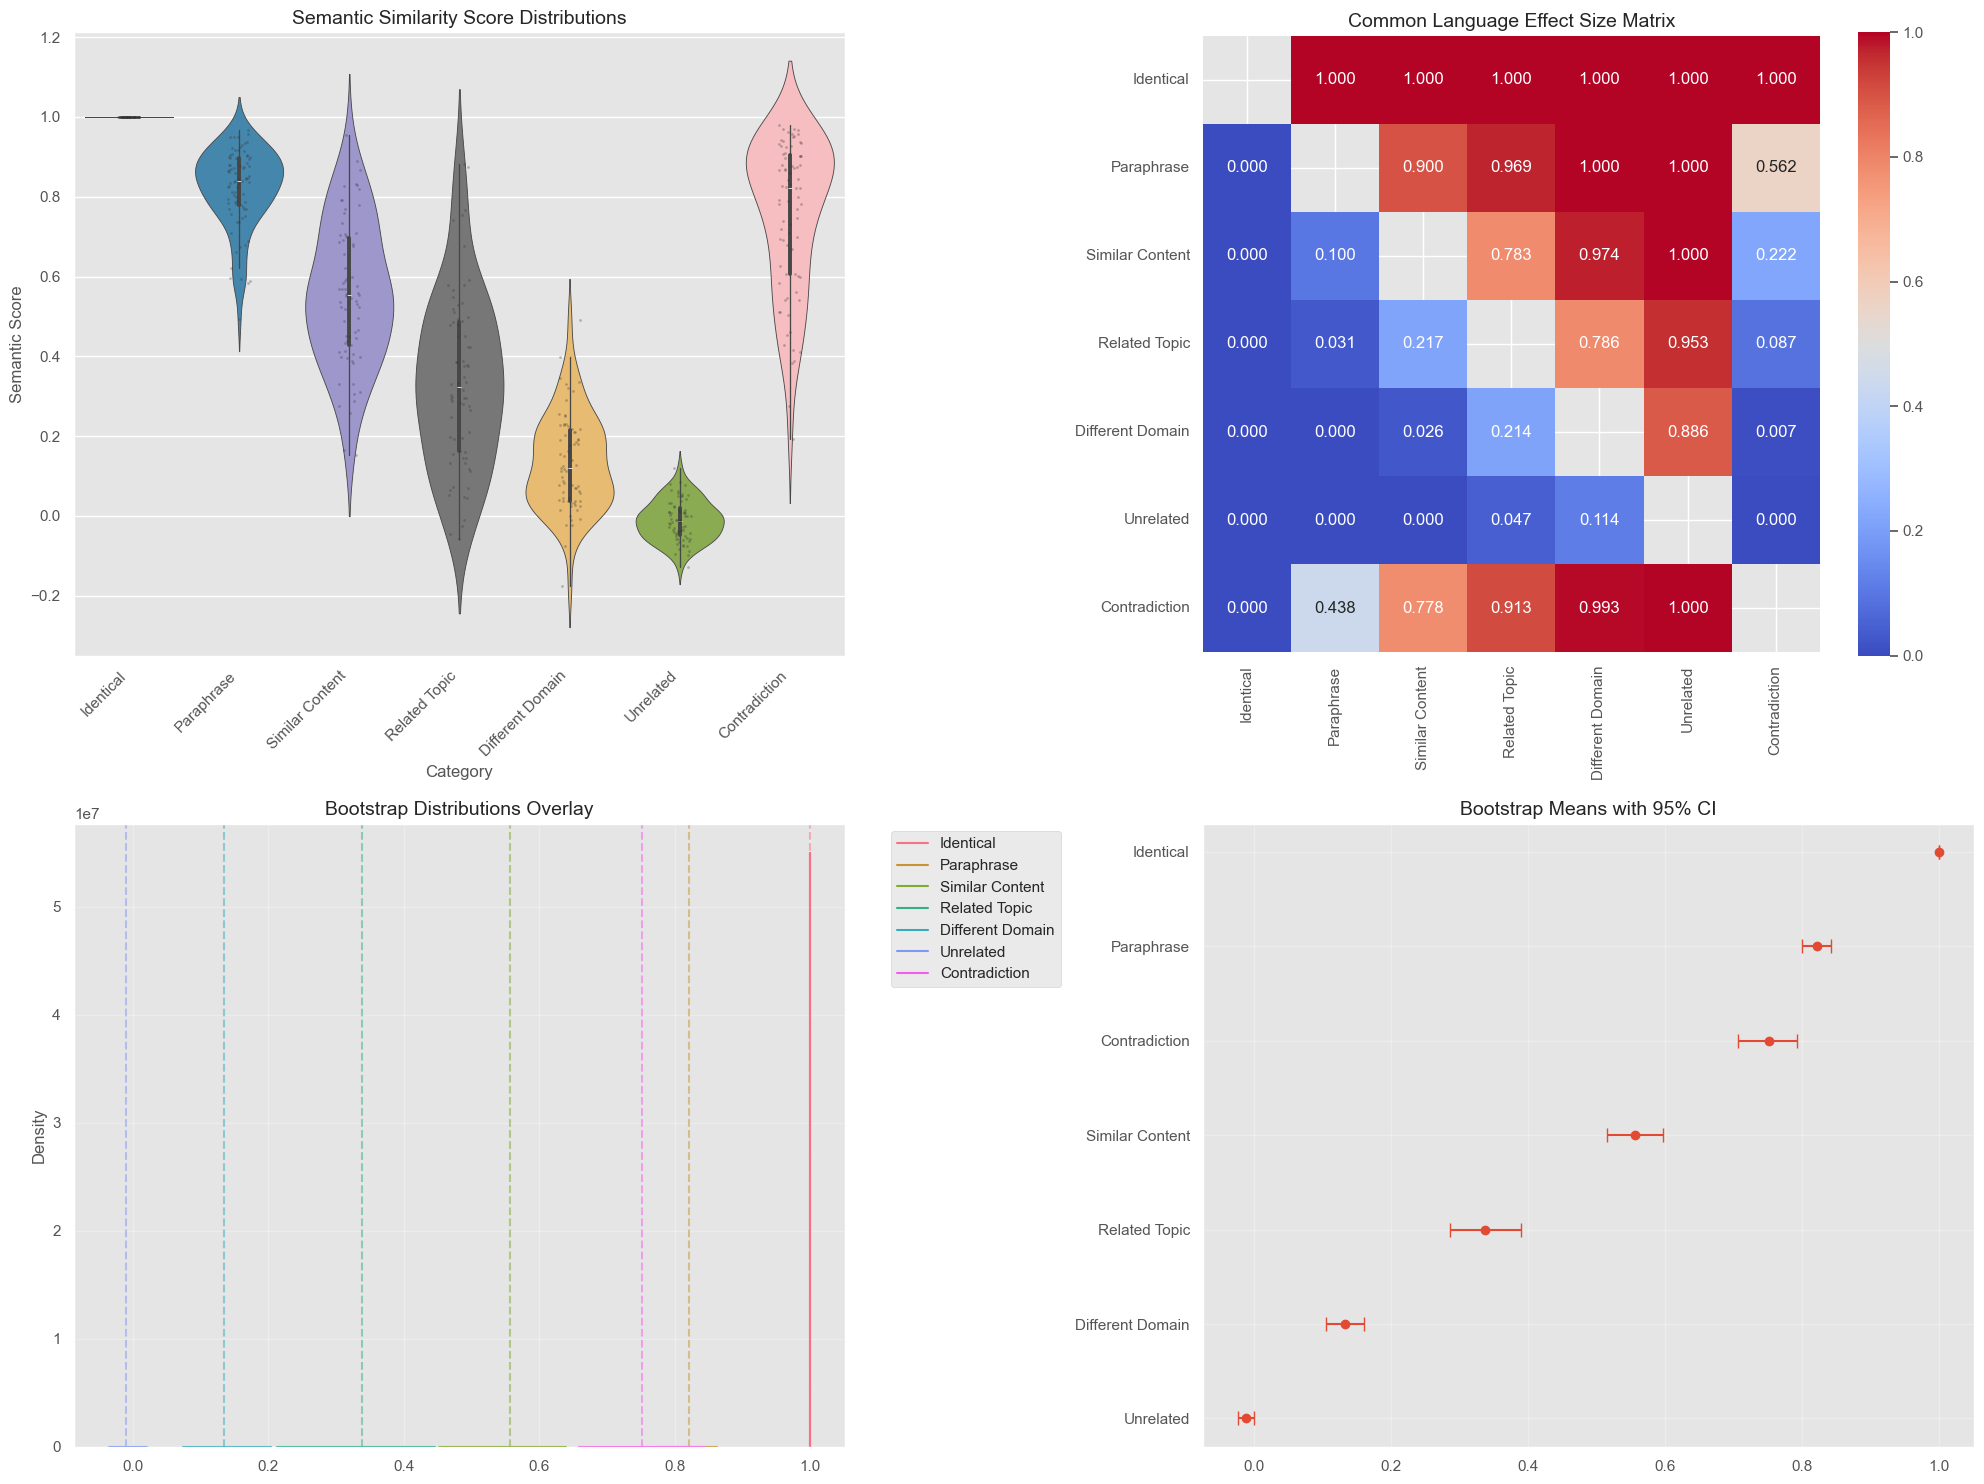

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Import revised SemScore modules
from semscore.metric.core import SemScoreMetric
from semscore.characterization.distributions import (
    analyze_category_distributions,
    generate_bootstrap_distributions,
    calculate_effect_matrices
)

# Set plotting style
# plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create output directory structure
base_dir = Path('semscore_characterization_results')
figures_dir = base_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

# Load characterization dataset
data_path = Path('semscore/data/characterization/SemScore_Characterization_Dataset.json')
with open(data_path, 'r') as f:
    raw_data = json.load(f)

# Initialize metric and compute scores
metric = SemScoreMetric()
category_scores = {}
for item in raw_data:
    category = item['category']
    score = metric(item['text1'], item['text2'])
    if category not in category_scores:
        category_scores[category] = []
    category_scores[category].append(score)

# Convert to numpy arrays
scores = {cat: np.array(scores) for cat, scores in category_scores.items()}

# Create figure grid
fig = plt.figure(figsize=(20, 15))
gs = plt.GridSpec(2, 2)

# 1. Category Distribution Plot (top left)
ax1 = fig.add_subplot(gs[0, 0])
colors = sns.color_palette("husl", n_colors=len(scores))

# Plot violin plots with individual points
plot_data = []
categories = []
for cat, data in scores.items():
    plot_data.extend(data)
    categories.extend([cat] * len(data))

df = pd.DataFrame({
    'Category': categories,
    'Semantic Score': plot_data
})

# Fix deprecated warning and overcrowding
sns.violinplot(data=df, x='Category', y='Semantic Score', 
               inner='box', hue='Category', legend=False)
# Use stripplot instead of swarmplot for better point placement
sns.stripplot(data=df, x='Category', y='Semantic Score', 
             color='0.2', alpha=0.3, size=2, jitter=True)

plt.xticks(rotation=45, ha='right')
ax1.set_title('Semantic Similarity Score Distributions')

# 2. CLES Matrix Heatmap (top right)
ax2 = fig.add_subplot(gs[0, 1])
d_matrix, cles_matrix = calculate_effect_matrices(scores)

mask = np.zeros_like(cles_matrix, dtype=bool)
np.fill_diagonal(mask, True)

sns.heatmap(cles_matrix, 
            annot=True, 
            cmap='coolwarm',
            center=0.5,
            mask=mask,
            fmt='.3f',
            square=True,
            ax=ax2)
ax2.set_title('Common Language Effect Size Matrix')

# 3. Bootstrap Distribution Plots (bottom)
bootstrap_data = generate_bootstrap_distributions(
    scores,
    n_bootstrap=10000,
    random_state=42
)

# Overlay plot (bottom left)
ax3 = fig.add_subplot(gs[1, 0])
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx],
                ax=ax3)
    
    # Add mean line
    mean = np.mean(dist)
    ax3.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5)

ax3.set_title('Bootstrap Distributions Overlay')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Statistical summary plot (bottom right)
ax4 = fig.add_subplot(gs[1, 1])
stats_data = []
for category, dist in bootstrap_data.items():
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    stats_data.append({
        'Category': category,
        'Mean': mean,
        'CI_Lower': ci[0],
        'CI_Upper': ci[1]
    })

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Mean', ascending=True)

# Plot mean and CI
ax4.errorbar(stats_df['Mean'], 
             range(len(stats_df)),
             xerr=[(stats_df['Mean'] - stats_df['CI_Lower']),
                   (stats_df['CI_Upper'] - stats_df['Mean'])],
             fmt='o',
             capsize=5)

ax4.set_yticks(range(len(stats_df)))
ax4.set_yticklabels(stats_df['Category'])
ax4.set_title('Bootstrap Means with 95% CI')
ax4.grid(True, alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.savefig(figures_dir / 'characterization_summary.png', 
            dpi=300, bbox_inches='tight')

# Save individual plots for detailed viewing
# Distribution plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='Category', y='Semantic Score', 
               inner='box', hue='Category', legend=False)
sns.stripplot(data=df, x='Category', y='Semantic Score', 
             color='0.2', alpha=0.3, size=2, jitter=True)
plt.xticks(rotation=45, ha='right')
plt.title('Semantic Similarity Score Distributions')
plt.tight_layout()
plt.savefig(figures_dir / 'category_distributions.png', 
            dpi=300, bbox_inches='tight')
plt.close()

# CLES Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cles_matrix, 
            annot=True, 
            cmap='coolwarm',
            center=0.5,
            mask=mask,
            fmt='.3f',
            square=True)
plt.title('Common Language Effect Size Matrix')
plt.tight_layout()
plt.savefig(figures_dir / 'cles_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.close()

# Bootstrap distributions
plt.figure(figsize=(15, 10))
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx])
    mean = np.mean(dist)
    plt.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5)
plt.title('Bootstrap Distributions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(figures_dir / 'bootstrap_distributions.png', 
            dpi=300, bbox_inches='tight')
plt.close()

print(f"Figures saved to {figures_dir}")

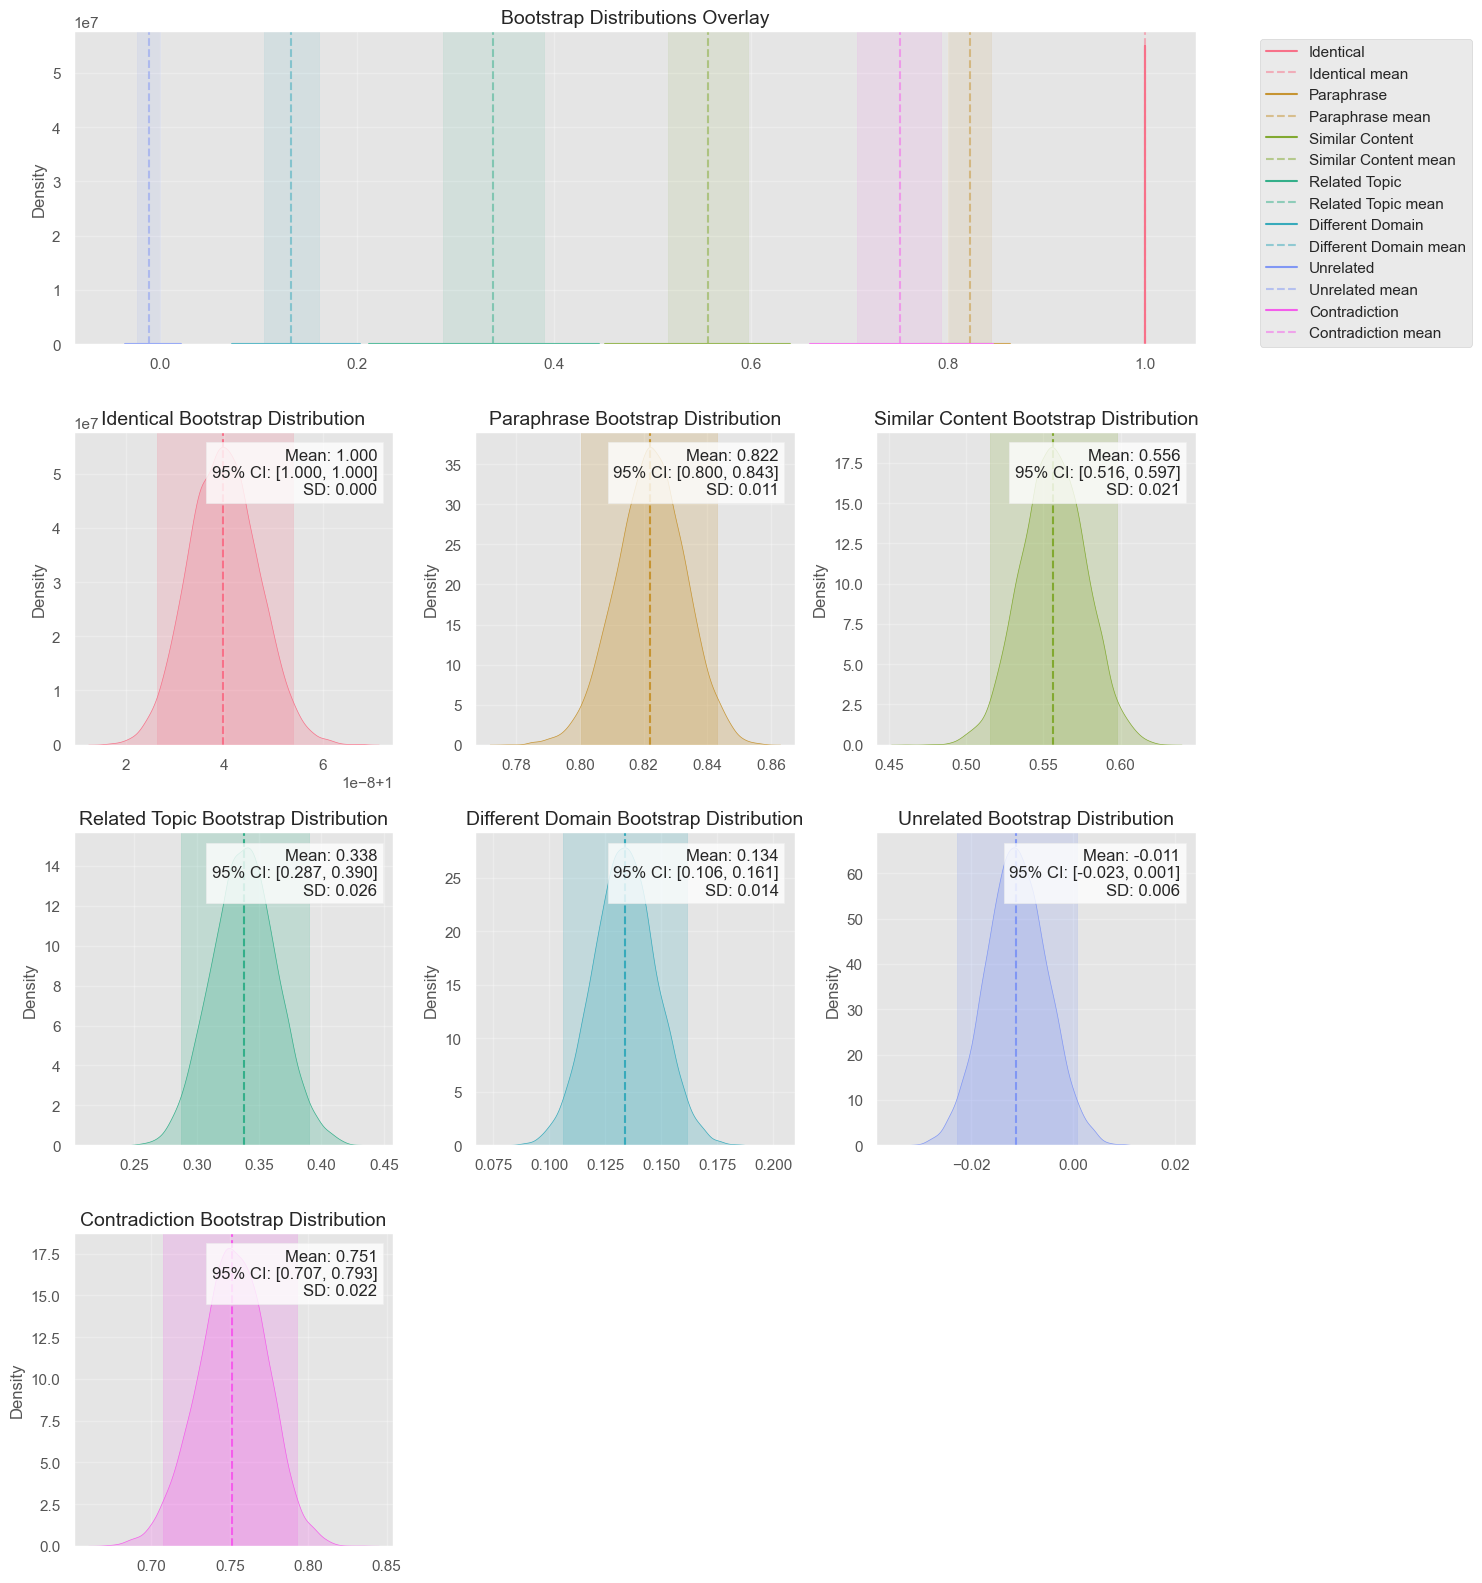

Detailed bootstrap analysis saved to semscore_characterization_results\figures/bootstrap_distributions_detailed.png


In [19]:
# Detailed Bootstrap Distribution Analysis
# Create subplot grid for individual bootstrap distributions
n_cats = len(bootstrap_data)
n_cols = 3
n_rows = (n_cats - 1) // n_cols + 2  # +1 for overlay plot

fig = plt.figure(figsize=(15, n_rows * 4))
gs = plt.GridSpec(n_rows, n_cols)

# Overlay plot (top row)
ax_overlay = fig.add_subplot(gs[0, :])
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx])
    
    # Add mean line and CI
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    ax_overlay.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5,
                      label=f'{category} mean')
    ax_overlay.axvspan(ci[0], ci[1], color=colors[idx], alpha=0.1)

ax_overlay.set_title('Bootstrap Distributions Overlay')
ax_overlay.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_overlay.grid(True, alpha=0.3)

# Individual distribution plots
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    row = 1 + idx // n_cols
    col = idx % n_cols
    
    ax = fig.add_subplot(gs[row, col])
    
    # Plot distribution
    sns.kdeplot(data=dist, color=colors[idx], fill=True)
    
    # Add mean and CI lines
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    
    ax.axvline(mean, color=colors[idx], linestyle='--', 
               label=f'Mean: {mean:.3f}')
    ax.axvspan(ci[0], ci[1], color=colors[idx], alpha=0.2,
               label=f'95% CI')
    
    # Add statistical annotations
    stats_text = (f'Mean: {mean:.3f}\n'
                 f'95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]\n'
                 f'SD: {np.std(dist):.3f}')
    
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_title(f'{category} Bootstrap Distribution')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'bootstrap_distributions_detailed.png', 
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"Detailed bootstrap analysis saved to {figures_dir}/bootstrap_distributions_detailed.png")